# What makes an NBA All-Star?
### STAT 206 Final Project

Description

In [143]:
import Pkg
Pkg.activate(pwd())
#Pkg.instantiate()
Pkg.status()



  Activating project at `~/STAT206_Final_Project`


Status `~/STAT206_Final_Project/Project.toml`
  [336ed68f] CSV v0.10.12
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.107
  [add582a8] MLJ v0.20.2


  [d354fa79] MLJClusteringInterface v0.1.11
  [094fc8d1] MLJFlux v0.4.0
  [61c7150f] MLJLIBSVMInterface v0.2.1
  [6ee0df7b] MLJLinearModels v0.10.0
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.3
  [636a865e] NearestNeighborModels v0.2.3
  [b8a86587] NearestNeighbors v0.4.16
  [91a5bcdd] Plots v1.40.1
  [860ef19b] StableRNGs v1.0.1
  [f3b207a7] StatsPlots v0.15.7
  [9a3f8284] Random


   Resolving package versions...


    Updating `~/STAT206_Final_Project/Project.toml`
  [da1fdf0e] + FreqTables v0.4.6
    Updating `~/STAT206_Final_Project/Manifest.toml`


  [da1fdf0e] + FreqTables v0.4.6
  [86f7a689] + NamedArrays v0.10.0


Precompiling 

project...


  ✓ MathOptInterface


  ✓ Optim


  ✓ MLJLinearModels
  3 dependencies successfully precompiled in 148 seconds. 357 already precompiled.
  3 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [133]:
using CSV, DataFrames
using Plots, StatsPlots
using Distributions
using MLJ, MLJClusteringInterface
using NearestNeighbors, StableRNGs, Random
#import PlotlyJS as PJS#import because PlotlyJS overwrites all plots and statsplots
#using Colors
using MLJLIBSVMInterface
using FreqTables

In [144]:
nbadf = CSV.read("nba_2022_2023.csv", DataFrame, stringtype = String) |> dropmissing
#describe(nbadf)
rename!(nbadf,
Symbol("FG%")=>:FGpct,
Symbol("3P")=>:ThreeP,
Symbol("3PA")=>:ThreePA,
Symbol("3P%")=>:ThreePpct,
Symbol("2P")=>:TwoP,
Symbol("2PA")=>:TwoPA,
Symbol("2P%")=>:TwoPpct,
Symbol("eFG%")=>:eFGpct,
Symbol("FT%")=>:FTpct,
:PTS=>:PPG
)

#Convert multi-positional to their main position
nbadf.Pos = first.(nbadf.Pos,2)
#filter(:Pos => in(["SG-PG","SF-SG","PG-SG","SF-PF","PF-C","PF-SF"]), nbadf)

allstars = CSV.read("nba_2022_2023_allstars.csv", DataFrame, stringtype = String)
leftjoin!(nbadf,allstars, on = :Player => :NAME)
replace!(nbadf.ALLSTAR, missing => "N")
#filter(:ALLSTAR=>==("Y"),nbadf)
nbadf.GSpct = nbadf.GS ./ nbadf.G
describe(nbadf)

31×7 DataFrame
 Row │ variable  mean      min         median    max              nmissing  el ⋯
     │ Symbol    Union…    Any         Union…    Any              Int64     Ty ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Player              A.J. Green            Zion Williamson         0  St ⋯
   2 │ Pos                 C                     SG                      0  St
   3 │ Age       26.1106   19          25.0      42                      0  In
   4 │ Tm                  ATL                   WAS                     0  St
   5 │ G         45.9359   1           48.0      83                      0  In ⋯
   6 │ GS        21.359    0           7.0       83                      0  In
   7 │ MP        20.3478   2.8         19.45     38.2                    0  Fl
   8 │ FG        3.42965   0.2         2.7       11.2                    0  Fl
  ⋮  │    ⋮         ⋮          ⋮          ⋮             ⋮            ⋮         ⋱
  25 │ STL       0.624199  0.0         0.6       2.2                     0  Fl ⋯
  26 │ BLK       0.38109   0.0         0.3       3.0                     0  Fl
  27 │ TOV       1.11843   0.0         0.9       4.1                     0  Fl
  28 │ PF        1.71763   0.0         1.7       5.0                     0  Fl
  29 │ PPG       9.37869   0.9         7.4       33.1                    0  Fl ⋯
  30 │ ALLSTAR             N                     Y                       0  Un
  31 │ GSpct     0.370371  0.0         0.166667  1.0                     0  Fl
                                                    1 column and 16 rows omitted

Columns Description:

1. Rk: Rank
2. Player: Player's name
3. Pos: Position
4. Age: Player's age
5. Tm: Team
6. G: Games played
7. GSpct: Games started percentage
8. MP: Minutes played per game
9. FG: Field goals per game
10. FGA: Field goal attempts per game
11. FGpct: Field goal percentage
12. ThreeP: 3-point field goals per game
13. ThreePA: 3-point field goal attempts per game
14. ThreePpct: 3-point field goal percentage
15. TwoP: 2-point field goals per game
16. TwoPA: 2-point field goal attempts per game
17. TwoPpct: 2-point field goal percentage
18. eFGpct: Effective field goal percentage
19. FT: Free throws per game
20. FTA: Free throw attempts per game
21. FTpct: Free throw percentage
22. ORB: Offensive rebounds per game
23. DRB: Defensive rebounds per game
24. TRB: Total rebounds per game
25. AST: Assists per game
26. STL: Steals per game
27. BLK: Blocks per game
28. TOV: Turnovers per game
29. PF: Personal fouls per game
30. PPG: Points per game
31. ALLSTAR: All-Star status

In [57]:
unique(first.(nbadf.Pos,2))

5-element Vector{String}:
 "C"
 "SG"
 "PF"
 "PG"
 "SF"

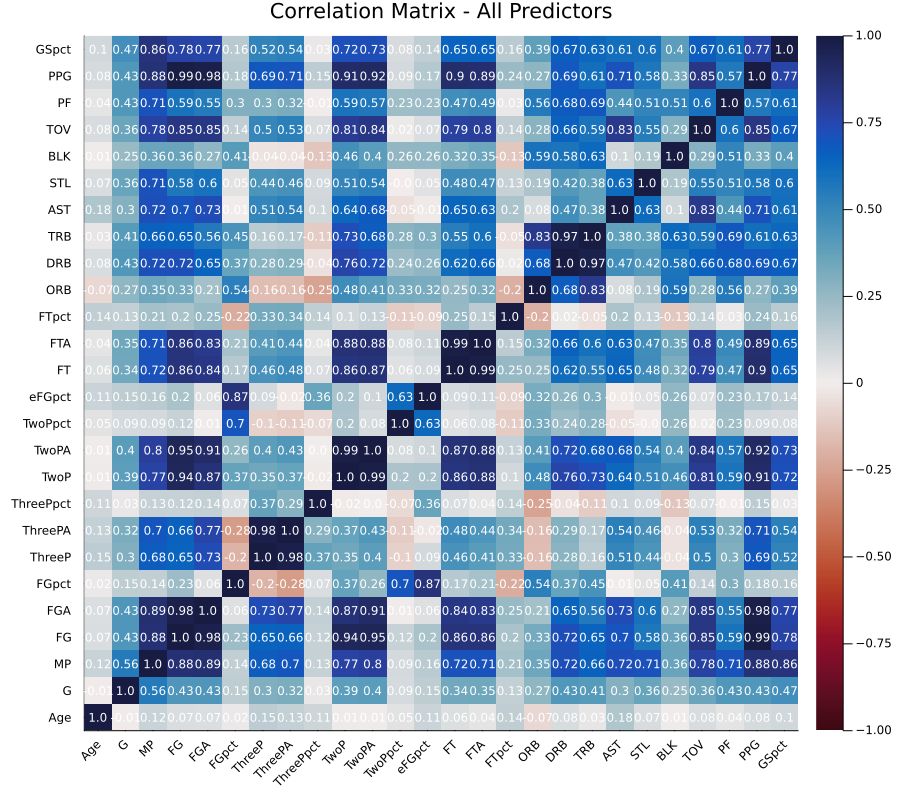

In [58]:
numeric_df = select(nbadf, Not([:Player, :Pos, :Tm, :ALLSTAR,:GS]))
vars = names(numeric_df)
X = Matrix(numeric_df)
M = cor(X)
fig = heatmap(M, 
    title="Correlation Matrix - All Predictors", 
    xticks=(1:26, vars), 
    yticks=(1:26, vars), 
    clims=(-1,1), 
    xrot=45,
    color=cgrad(:balance, rev=true), 
    aspect=:ratio, 
    size=(900, 800)
)

for j in axes(M,2), i in axes(M,1)
    annotate!(i,j, text("$(round(M[i,j], digits=2))", :white, 8))
end 
fig 

### Check for multicollinearity
+ Shot attempts: high correlation between made shots and attempts, better to use shots made and shot pct
+ eFGpct: According to [basketball-reference.com](https://www.basketball-reference.com/about/glossary.html), eFGpct = (FG + 0.5 * 3P) / FGA which is a linear equation of predictors
+ Field Goals: Field goals is just 2P + 3P, so it is collinear
+ Total Rebounds: Total rebounds is offensive + defensive rebounds, which is collinear
+ Recommendation: Remove these predictors when creating linear models

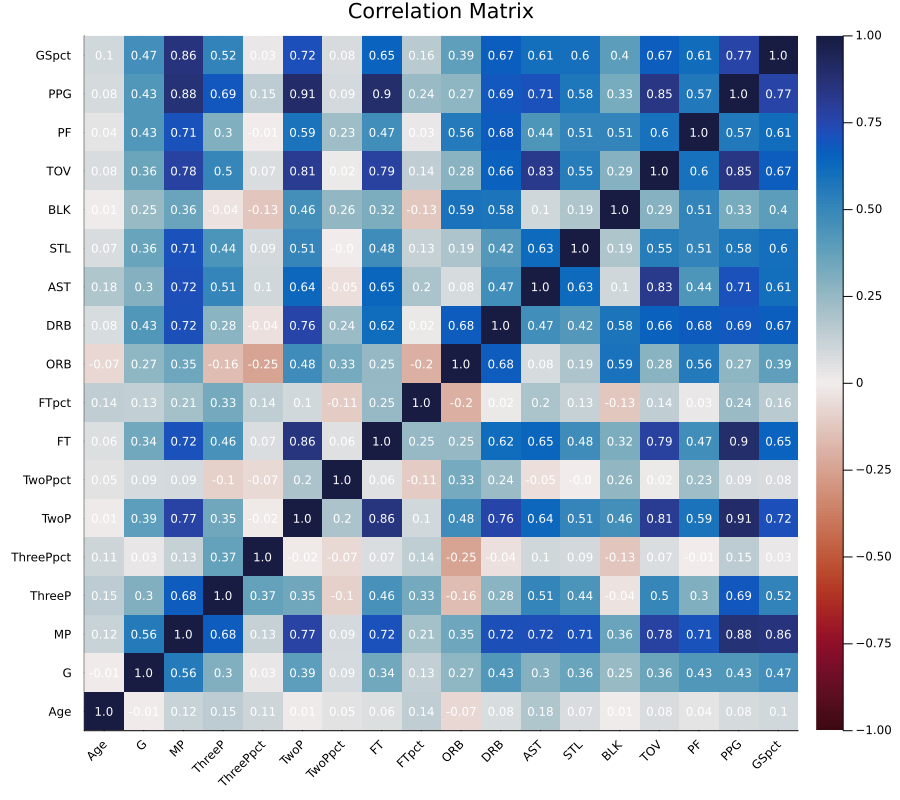

In [59]:
vars = names(select(numeric_df, Not([:FG,:FGA,:FGpct,:ThreePA,:TwoPA,:FTA,:TRB,:eFGpct])))
X = Matrix(select(numeric_df, Not([:FG,:FGA,:FGpct,:ThreePA,:TwoPA,:FTA,:TRB,:eFGpct])))
M = cor(X)
fig = heatmap(M, 
    title="Correlation Matrix", 
    xticks=(1:18, vars), 
    yticks=(1:18, vars), 
    clims=(-1,1), 
    xrot=45,
    color=cgrad(:balance, rev=true), 
    aspect=:ratio, 
    size=(900, 800)
)

for j in axes(M,2), i in axes(M,1)
    annotate!(i,j, text("$(round(M[i,j], digits=2))", :white, 8))
end 
fig 

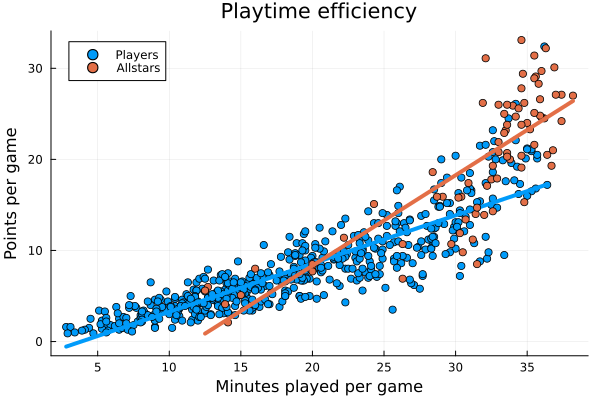

In [60]:
# To make a ColorGradient for Heatmaps: color_palette = cgrad(Sample color scheme = :roma, scale = :log))
@df nbadf scatter(:MP, :PPG, group = :ALLSTAR, 
smooth = true, linewidth = 4,
title = "Playtime efficiency",
xlabel = "Minutes played per game",
ylabel = "Points per game",
label = ["Players" "Allstars"])

In [85]:
filter(row->row.ALLSTAR==("Y") && row.MP<27,nbadf)

13×31 DataFrame
 Row │ Player           Pos     Age    Tm      G      GS     MP       FG       ⋯
     │ String           String  Int64  String  Int64  Int64  Float64  Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Andre Drummond   C          29  CHI        67      0     12.7      2.5  ⋯
   2 │ Blake Griffin    C          33  BOS        41     16     13.9      1.5
   3 │ Andre Iguodala   PF         39  GSW         8      0     14.1      0.9
   4 │ DeAndre Jordan   C          34  DEN        39      8     15.0      2.3
   5 │ Kevin Love       PF         34  TOT        62     20     20.0      2.7  ⋯
   6 │ Kevin Love       PF         34  CLE        41      3     20.0      2.7
   7 │ Kevin Love       PF         34  MIA        21     17     20.0      2.6
   8 │ Khris Middleton  SF         31  MIL        33     19     24.3      5.4
   9 │ Victor Oladipo   SG         30  MIA        42      2     26.3      3.8  ⋯
  10 │ Derrick Rose     PG         34  NYK        27      0     12.5      2.3
  11 │ Ben Simmons      PG         26  BRK        42     33     26.3      3.2
  12 │ Kemba Walker     PG         32  DAL         9      1     16.0      2.7
  13 │ John Wall        PG         32  LAC        34      3     22.2      4.1  ⋯
                                                              23 columns omitted

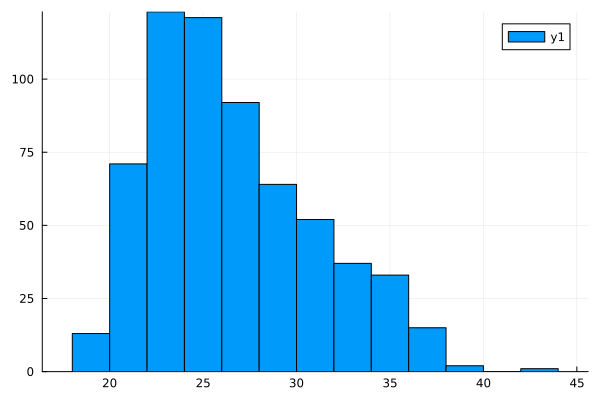

In [62]:
histogram(nbadf.Age)

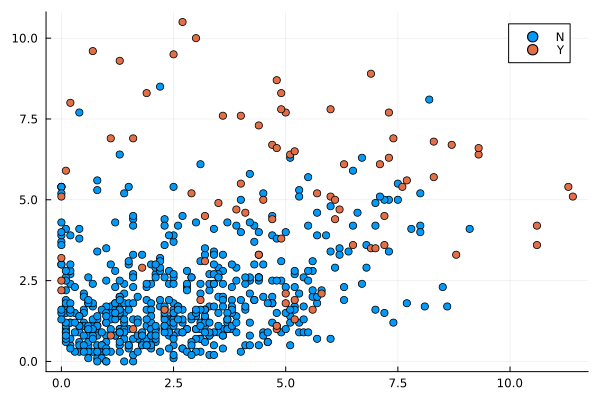

In [63]:
@df nbadf scatter(:ThreePA, :TwoP, group = :ALLSTAR)

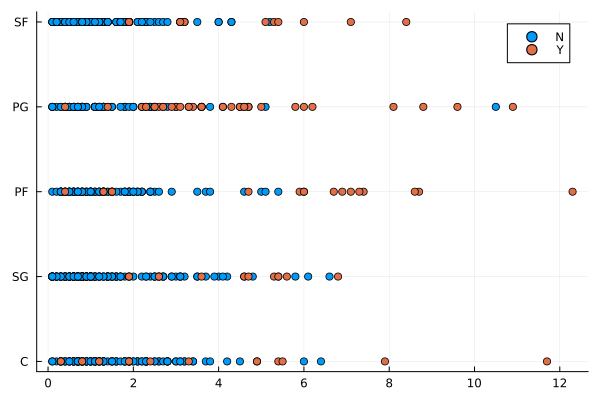

In [64]:
scatter(nbadf.FTA, nbadf.Pos,group = nbadf.ALLSTAR)


## PCA Analysis

In [65]:
features = names(numeric_df)
# load the PCA model
PCA = @load PCA pkg = MultivariateStats

# Standarize -> PCA w/ 97.5% variance.
# The mean = 0 option means we do not need to center the data.
model = Pipeline(Standardizer(), PCA(variance_ratio = 0.975))

# Fit the machine.
mach = machine(model, numeric_df) |> MLJ.fit!

# Apply a transformation to the numeric data and convert to Matrix.
Xproj = MLJ.transform(mach, numeric_df) |> Matrix

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/mattbarclay/.julia/packages/MLJModels/iFOi9/src/loading.jl:159
┌ Info: Training machine(UnsupervisedPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/mIaqI/src/machines.jl:493
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/mIaqI/src/machines.jl:493
┌ Info: Training machine(:pca, …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/mIaqI/src/machines.jl:493


624×3 Matrix{Float64}:
  -9.08569   3.22495   -0.303497
   3.65375  -2.91003   -3.1669
 -29.5008    0.673202  -5.10255
 -12.9423    4.30555    1.68504
 -31.0019    4.32934    1.59496
 -12.8754    2.45629    2.67212
  10.0323    2.16418    0.654099
  23.0703    2.24436    0.621729
 -26.0588   -0.892639   1.37733
 -22.3593    1.9448    -3.10022
   ⋮                   
 -21.2821   -1.15781   -2.09916
  -4.06125  -3.87201    0.859033
  19.1149    2.35092    1.29862
  42.9338   -3.20406   -0.970443
  -7.89554  -7.35252    3.60504
 -27.5303    1.08542   -6.50796
  37.0271    2.1189    -0.21433
  30.9305   -3.77711   -0.653512
 -30.2569    1.2137    -1.23723

In [66]:
r = report(mach).pca

(indim = 26,
 outdim = 3,
 tprincipalvar = 579.2148387931695,
 tresidualvar = 11.460612394219083,
 tvar = 590.6754511873886,
 mean = [26.110576923076923, 45.93589743589744, 1.8414756898830723e-16, -2.2506925098570883e-16, -9.781171599161536e-17, 9.515180666178426e-16, -9.394194823751324e-17, 2.697272604698297e-16, 2.974828360854586e-16, 1.6546593155471083e-16  …  2.846725704167068e-17, 3.9854159858338954e-16, -4.981769982292369e-17, -3.613562440727072e-16, -1.6368672798960642e-17, 2.0354088784794536e-16, 3.9444943038364937e-16, -7.540264708912522e-16, 3.3520195166567226e-16, 2.2062124207294778e-16],
 principalvars = [550.5587175841916, 19.38312487734269, 9.272996331635238],
 loadings = [0.03333910911308814 -4.34576862428838 0.4232362996772235; -23.399746181757223 0.039614737760890695 0.21878857093024734; … ; -0.43416507933499143 -0.17210159358815308 -0.8470648804421724; -0.47424561902072393 -0.16573060080414176 -0.6700187416933681],)

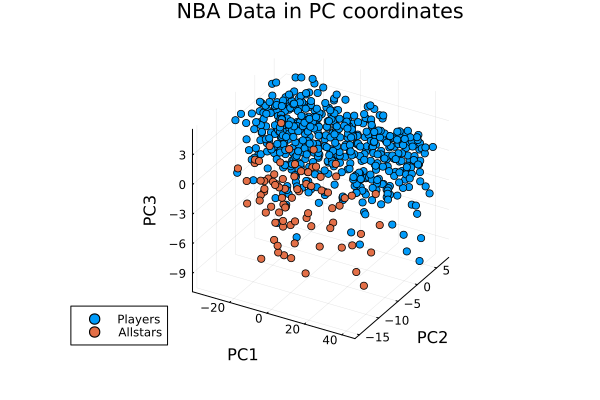

In [67]:
y = nbadf[:, :ALLSTAR] |> Vector
scatter(Xproj[:, 1], Xproj[:, 2], Xproj[:, 3],
  group = y,
  title = "NBA Data in PC coordinates",
  xlabel = "PC1",
  ylabel = "PC2",
  zlabel = "PC3",
  label = ["Players" "Allstars"]
)

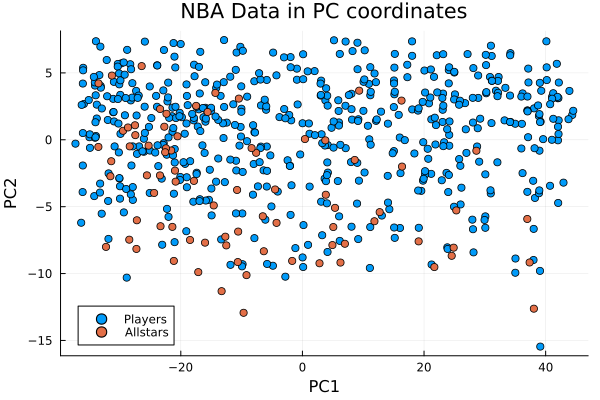

In [68]:
y = nbadf[:, :ALLSTAR] |> Vector
scatter(Xproj[:, 1], Xproj[:, 2],
  group = y,
  title = "NBA Data in PC coordinates",
  xlabel = "PC1",
  ylabel = "PC2",
  label = ["Players" "Allstars"]
)

In [69]:
include("plotvec.jl")
default(fmt = :png, dpi = 100)


In [70]:
L = r.loadings
loadings_df = hcat(
  DataFrame(feature = features),
  DataFrame(L, :auto)
)

rename!(loadings_df, [:feature, :PC1, :PC2, :PC3])
loadings_df

26×4 DataFrame
 Row │ feature    PC1          PC2         PC3        
     │ String     Float64      Float64     Float64    
─────┼────────────────────────────────────────────────
   1 │ Age          0.0333391  -4.34577     0.423236
   2 │ G          -23.3997      0.0396147   0.218789
   3 │ MP          -0.563878   -0.197294   -0.717069
   4 │ FG          -0.440643   -0.156748   -0.852326
   5 │ FGA         -0.438774   -0.155238   -0.822988
   6 │ FGpct       -0.150588   -0.0393222  -0.213674
   7 │ ThreeP      -0.308982   -0.217756   -0.469547
   8 │ ThreePA     -0.321455   -0.19902    -0.487941
  ⋮  │     ⋮           ⋮           ⋮           ⋮
  20 │ AST         -0.302969   -0.255243   -0.64868
  21 │ STL         -0.369224   -0.1313     -0.516939
  22 │ BLK         -0.250731   -0.0374938  -0.372023
  23 │ TOV         -0.365904   -0.157399   -0.791796
  24 │ PF          -0.431817   -0.0944178  -0.553201
  25 │ PPG         -0.434165   -0.172102   -0.847065
  26 │ GSpct       -0.474246   -0.165731   -0.670019
                                       11 rows omitted

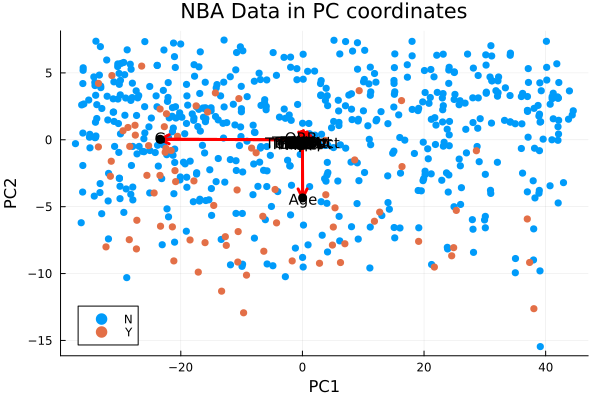

In [71]:
fig = scatter(Xproj[:, 1], Xproj[:, 2],
  group = y,
  title = "NBA Data in PC coordinates",
  xlabel = "PC1",
  ylabel = "PC2",
  markerstrokewidth = 0,
)
ls = [L[i,1:2] for i in axes(L, 1)]
plotvec!(fig, ls, color = :red)
for (k, loading) in enumerate(ls)
  annotate!(fig, loading[1], loading[2] + sign(loading[2])*0.1, text(features[k], :black, 10))
end
fig

#### Interactive scatterplot from PlotlyJS

In [72]:
# PCA_df = DataFrame(:ALLSTAR=>nbadf[:,:ALLSTAR],:X1=>Xproj[:, 1],:X2=>Xproj[:, 2],:X3=>Xproj[:,3])

# colors = [RGB(18/255, 133/255, 248/255), RGB(217/255, 89/255, 56/255)]
# data = PJS.GenericTrace[]
# df = filter(:ALLSTAR=>==("N"),PCA_df)
# PC1=df[:,:X1]
# PC2=df[:,:X2]
# PC3=df[:,:X3]
# trace = PJS.scatter3d(name="Players", mode="markers",
#                     marker_size=3, marker_color=colors[1], marker_line_width=0,
#                     x=PC1, y=PC2, z=PC3)
# push!(data, trace)
# cluster = PJS.mesh3d(color=colors[1], opacity=0.3, x=PC1, y=PC2, z=PC3)
# push!(data, cluster)

# df = filter(:ALLSTAR=>==("Y"),PCA_df)
# PC1=df[:,:X1]
# PC2=df[:,:X2]
# PC3=df[:,:X3]
# trace = PJS.scatter3d(name="Allstars", mode="markers",
#                     marker_size=3, marker_color=colors[2], marker_line_width=0,
#                     x=PC1, y=PC2, z=PC3)
# push!(data, trace)
# cluster = PJS.mesh3d(color=colors[2], opacity=0.3, x=PC1, y=PC2, z=PC3)
# push!(data, cluster)
# # notice the nested attrs to create complex JSON objects
# layout = PJS.Layout(width=800, height=550, autosize=false, title="Interactive NBA Data in PC coordinates",
#                 scene=PJS.attr(xaxis=PJS.attr(gridcolor="rgb(255, 255, 255)",
#                                         zerolinecolor="rgb(255, 255, 255)",
#                                         showbackground=true,
#                                         backgroundcolor="rgb(230, 230,230)",
#                                         title = "PC1"),
#                             yaxis=PJS.attr(gridcolor="rgb(255, 255, 255)",
#                                         zerolinecolor="rgb(255, 255, 255)",
#                                         showbackground=true,
#                                         backgroundcolor="rgb(230, 230,230)",
#                                         title = "PC2"),
#                             zaxis=PJS.attr(gridcolor="rgb(255, 255, 255)",
#                                         zerolinecolor="rgb(255, 255, 255)",
#                                         showbackground=true,
#                                         backgroundcolor="rgb(230, 230,230)",
#                                         title = "PC3"),
#                             aspectratio=PJS.attr(x=1, y=1, z=0.7),
#                             aspectmode = "manual"),
#                             scene_camera = PJS.attr(eye=PJS.attr(x=1.25, y=-2, z=.75) # Try to match Plots output
#                             ))
# # p = PJS.plot(data, layout)
# # open("./PCA3D.html", "w") do io
# #     PJS.PlotlyBase.to_html(io, p.plot)
# # end

<iframe width=900 height=600 src="./PCA3D.html"></iframe>

In [126]:
KMeans = @load KMeans pkg = Clustering verbosity=0
rng = StableRNG(206)




standardizer = Standardizer()
kmeans = KMeans(k=2)
pipeline_model = Pipeline(standardizer,kmeans)

machine1 = machine(pipeline_model, numeric_df)
fit!(machine1)
r = report(machine1)
#@show r.k_means


┌ Info: Training machine(UnsupervisedPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/mIaqI/src/machines.jl:493


length((filter(:ALLSTAR => (==)("Y"), pred_allstars)).ALLSTAR) / length(pred_allstars.ALLSTAR) = 0.1661721068249258


┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/mIaqI/src/machines.jl:493
┌ Info: Training machine(:k_means, …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/mIaqI/src/machines.jl:493


0.9198606271777003

In [127]:
pred_allstars = nbadf[r.k_means.assignments .== 1,:]
pred_players = nbadf[r.k_means.assignments .== 2,:]
@show length(filter(:ALLSTAR=>==("Y"),pred_allstars).ALLSTAR)/length(pred_allstars.ALLSTAR)
length(filter(:ALLSTAR=>==("N"),pred_players).ALLSTAR)/length(pred_players.ALLSTAR)

length((filter(:ALLSTAR => (==)("Y"), pred_allstars)).ALLSTAR) / length(pred_allstars.ALLSTAR) = 0.1661721068249258


0.9198606271777003

In [134]:
y = categorical(String.(nbadf[!, :ALLSTAR]), levels = ["Y", "N"])
X = numeric_df

2-element Vector{String}:
 "Y"
 "N"

In [135]:
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=1234);
acc = Float64[] # accuracy()
pre = Float64[] # multiclass_precision()
rec = Float64[] # multiclass_recall()
f1s = Float64[] # f1score()
mat = []        # confusion_matrix()

Any[]

In [142]:
KNNClassifier = @load KNNClassifier verbosity = 0
LDA = @load LDA verbosity = 0
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg = MLJFlux verbosity = 0
MultinomialClassifier = @load MultinomialClassifier verbosity = 0

model_list = [
    KNNClassifier(K = 5), # use nearest 5-neighbors to make predictions
    LDA(),
    NeuralNetworkClassifier(),
    MultinomialClassifier()
]

┌ Warning: Module ForwardDiff with build ID ffffffff-ffff-ffff-0000-54bc7320df07 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942


┌ Warning: Module ForwardDiff with build ID ffffffff-ffff-ffff-0000-54bc7320df07 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942


┌ Warning: Module ForwardDiff with build ID ffffffff-ffff-ffff-0000-54bc7320df07 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942


┌ Warning: Module NLSolversBase with build ID ffffffff-ffff-ffff-0000-55025f411e37 is missing from the cache.
│ This may mean NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942


┌ Warning: Module ForwardDiff with build ID ffffffff-ffff-ffff-0000-54bc7320df07 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942


4-element Vector{Probabilistic}:
 KNNClassifier(K = 5, …)
 LDA(method = gevd, …)
 NeuralNetworkClassifier(builder = Short(n_hidden = 0, …), …)
 MultinomialClassifier(lambda = 2.220446049250313e-16, …)

In [145]:
for clf in model_list
    # Create a pipeline model that standardizes, then fits a classifier.
    model = Pipeline(Standardizer(), clf)

    # Fit the model onto the training set
    mach = machine(model, X, y)
    fit!(mach, rows = train, verbosity = 0)

    # Make predictions on the test set
    yhat = MLJ.predict(mach, rows = test)

    # Evaluate the model on the test set using selected metrics
    #
    # NOTES:
    #
    #   - MLJ.predict() may give probabilistic predictions. Use mode() to collapse to a concrete target.
    #   - An evaluation metric F() always accepts inputs as F(fitted, observed).
    #
    push!(acc, accuracy(mode.(yhat), y[test]))
    push!(pre, multiclass_precision(mode.(yhat), y[test]))
    push!(rec, multiclass_recall(mode.(yhat), y[test]))
    push!(f1s, f1score(mode.(yhat), y[test]))
    push!(mat, ConfusionMatrix(levels = levels(y))(mode.(yhat), y[test]))
end

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{String, UInt32}["Y", "N"]. The "positive" level is N. 
└ @ StatisticalMeasures.ConfusionMatrices /Users/mattbarclay/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{String, UInt32}["Y", "N"]. The "positive" level is N. 
└ @ StatisticalMeasures.ConfusionMatrices /Users/mattbarclay/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(26 => 7, σ)
│   summary(x) = 26×1 Matrix{Float64}
└ @ Flux /Users/mattbarclay/.julia/packages/Flux/vzwqj/src/layers/stateless.jl:60


┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{String, UInt32}["Y", "N"]. The "positive" level is N. 
└ @ StatisticalMeasures.ConfusionMatrices /Users/mattbarclay/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{String, UInt32}["Y", "N"]. The "positive" level is N. 
└ @ StatisticalMeasures.ConfusionMatrices /Users/mattbarclay/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


In [146]:
results = DataFrame(
    Model = typeof.(model_list),
    Accuracy = acc,
    Precision = pre,
    Recall = rec,
    F1 = f1s
)

4×5 DataFrame
 Row │ Model                              Accuracy  Precision  Recall    F1    ⋯
     │ DataType                           Float64   Float64    Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ KNNClassifier                         0.888   0.941176  0.65      0.937 ⋯
   2 │ LDA                                   0.888   0.78749   0.852381  0.931
   3 │ NeuralNetworkClassifier{Short, t…     0.84    0.42      0.5       0.913
   4 │ MultinomialClassifier                 0.896   0.825758  0.755952  0.939
                                                                1 column omitted

In [147]:
mat[1]  # KNNClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  Y   │  N   │
├─────────┼──────┼──────┤
│    Y    │  6   │  0   │
├─────────┼──────┼──────┤
│    N    │  14  │ 105  │
└─────────┴──────┴──────┘


In [148]:
mat[2]  # LDA

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  Y   │  N   │
├─────────┼──────┼──────┤
│    Y    │  16  │  10  │
├─────────┼──────┼──────┤
│    N    │  4   │  95  │
└─────────┴──────┴──────┘


In [149]:
mat[3]  # NeuralNetworkClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  Y   │  N   │
├─────────┼──────┼──────┤
│    Y    │  0   │  0   │
├─────────┼──────┼──────┤
│    N    │  20  │ 105  │
└─────────┴──────┴──────┘


In [150]:
mat[4]  # MultinomialClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  Y   │  N   │
├─────────┼──────┼──────┤
│    Y    │  11  │  4   │
├─────────┼──────┼──────┤
│    N    │  9   │ 101  │
└─────────┴──────┴──────┘


Base.Meta.ParseError: ParseError:
# Error @ /Users/mattbarclay/STAT206_Final_Project/Final Project.ipynb:1:1
?multiclass_precision()
╙ ── not a unary operator

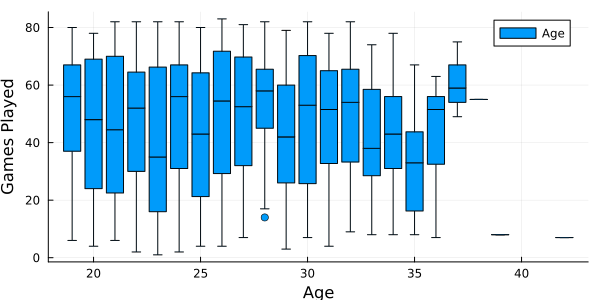

In [ ]:
boxplot(nbadf.Age, nbadf.G, xlabel="Age", ylabel="Games Played", label=["Age" "Games Played"], 
size=(600, 300))
